In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

In [2]:
# download the data
df = yf.download(tickers=['AAPL'], period='1y')
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

[*********************100%***********************]  1 of 1 completed


In [3]:
# fit the model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=64))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=32, verbose=0)


<AxesSubplot:title={'center':'AAPL'}, xlabel='Date'>

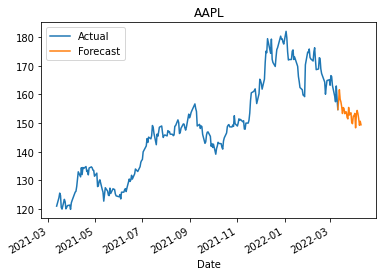

In [9]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = pd.concat([df_past, df_future]).set_index('Date')


# plot the results
results.plot(title='AAPL')